In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

In [6]:
df = pd.read_csv("data.csv", encoding = "ISO-8859-1")
x = df["no2"].dropna().values.reshape(-1, 1)    # feature column

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13364\262610769.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding = "ISO-8859-1")


In [11]:
roll_num = 102316037    # seeding parameters

a_r = 0.5 * (roll_num % 7)
b_r = 0.3 * (roll_num % 5 + 1)

In [23]:
# print(x)
z = x + a_r * np.sin(b_r * x)    # trasnformed feature column
print(x, z, sep = '\t')

[[17.4]
 [ 7. ]
 [28.5]
 ...
 [45. ]
 [50. ]
 [46. ]]	[[17.5198622 ]
 [ 7.04203475]
 [29.73624846]
 ...
 [45.83537794]
 [52.12725881]
 [44.67352706]]


In [25]:
# normalising the transformed feature column
z_mean = z.mean()
z_std = z.std()
z_normalized = (z - z_mean) / z_std
real_data = torch.FloatTensor(z_normalized)

In [26]:
# GAN
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1) # Output is z_f
        )
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid() # Binary classification
        )
    def forward(self, x):
        return self.model(x)

In [27]:
# CORE TRAINING SECTION

# initialization
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

epochs = 5000
batch_size = 128

for epoch in range(epochs):
    # train Discriminator
    idx = np.random.randint(0, real_data.size(0), batch_size)
    real_samples = real_data[idx]
    
    # Generate fake samples from N(0,1) noise
    noise = torch.randn(batch_size, 1)
    fake_samples = generator(noise)
    
    # Labels
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)
    
    # D Loss
    d_loss_real = criterion(discriminator(real_samples), real_labels)
    d_loss_fake = criterion(discriminator(fake_samples.detach()), fake_labels)
    d_loss = d_loss_real + d_loss_fake
    
    optimizer_D.zero_grad()
    d_loss.backward()
    optimizer_D.step()
    
    # train Generator
    g_loss = criterion(discriminator(fake_samples), real_labels)
    
    optimizer_G.zero_grad()
    g_loss.backward()
    optimizer_G.step()

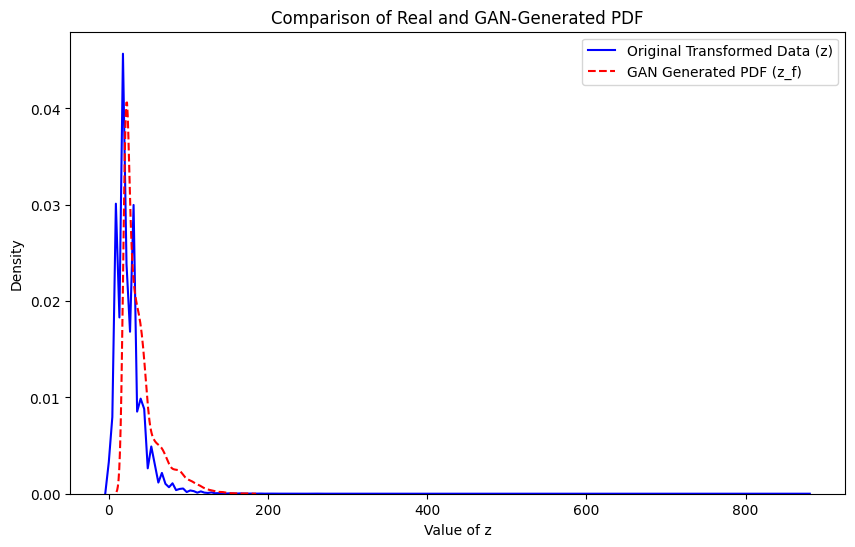

In [28]:
# Generating samples and estimating P.D.F.
with torch.no_grad():
    test_noise = torch.randn(10000, 1)
    generated_z = generator(test_noise).numpy()

# de-normalize (so as to not follow the Gaussian Normal distribution)
generated_z = (generated_z * z_std) + z_mean

# plot the P.D.F.
plt.figure(figsize=(10, 6))
sns.kdeplot(z.flatten(), label='Original Transformed Data (z)', color='blue')
sns.kdeplot(generated_z.flatten(), label='GAN Generated PDF (z_f)', color='red', linestyle='--')
plt.title("Comparison of Real and GAN-Generated PDF")
plt.xlabel("Value of z")
plt.ylabel("Density")
plt.legend()
plt.show()